# Benchmarking GPT3 for abductive reasoning

This notebook will benchmark the abductive reasoning of GPT3 by prompting it to solve detective puzzles from the dataset we gathered from the 5minutemystery.com website.

In [1]:
# !pip install openai
# !pip install langchain

In [2]:
import os
# os.environ["OPENAI_API_KEY"] = "..."

Experiments to compare:
1. Zero-shot + Instruction + "Let's think step-by-step" chain of though prompt
2. Zero-shot + Instruction prompt
3. Zero-shot + Instruction + Full answer prompt
4. Few-shot prompt

Future work:
1. Self-consistency
2. Model type: Vanilla GPT3 vs InstructGPT vs HuggingFace Models
3. Model scale: Small vs Medium vs Large vs XLarge (does abductive reasoning emerge with larger models?)
4. Model class: MLM/CLM/Seq2seq?

### Prompt template

Below we define pieces of prompt that we use to compose a prompt template

In [3]:
instruction = """Your task is to solve a given mystery.
The mystery is a detective puzzle presented as a short story.
You will be given a list of answer options apart from the mystery content. 
Please give your final answer as
(x) Your Answer
where x is the number of the answer option.
Only one answer from the list is correct, and your task is to identify which one.\n\n\n"""

mystery_body = """Answer options: {suspects}.

Mystery content:
{mystery_name}

{mystery_content}"""

stepbystep = """\n\nFull answer: 
Let's think step by step."""

cot = """\n\nFull answer: 
{mystery_full_answer}"""

final_q = """\n\nFinal answer:"""

In [4]:
stub_model_response = """ Stub Chain of Thought."""

prompt_zeroshot = mystery_body + final_q
prompt_zeroshot_instruct = instruction + mystery_body + final_q
prompt_zeroshot_instruct_stepbystep = instruction + mystery_body + stepbystep + stub_model_response + final_q
prompt_zeroshot_stepbystep = mystery_body + stepbystep + stub_model_response + final_q

prompt_fewshot_instruct_cot_answer = "..."
prompt_fewshot_instruct_cot = "..."
prompt_fewshot_instruct_answer = "..."

prompt_fewshot_cot_answer = "..."
prompt_fewshot_cot = "..."
prompt_fewshot_answer = "..."

In [5]:
from langchain import PromptTemplate, OpenAI, LLMChain
from langchain.chains import SequentialChain
from collections import defaultdict
import pandas as pd

In [6]:
predictions = defaultdict(list)
predictions_chain_of_thought = defaultdict(list)

df = pd.read_csv("detective-puzzles.csv")

### Evaluation utils

In [7]:
def same_answers(pred_a: str, true_a: str):
    if pred_a != true_a:
        # discard dot at the end of answers
        pred_a, true_a = strip_answers(pred_a, true_a)
    
    return int(pred_a == true_a)

def strip_answers(pred_a, true_a):
    pred_a = pred_a[:-1] if pred_a[-1] == "." else pred_a
    true_a = true_a[:-1] if true_a[-1] == "." else true_a

    # discard (x) at the beginning of answers
    pred_a = pred_a[3:]
    true_a = true_a[3:]
    return pred_a,true_a

def compute_solve_rate(pred_answers, true_answers):
    solve_rate = 0
    for pred_a, true_a in zip(pred_answers, true_answers):
        if same_answers(pred_a, true_a):
            solve_rate += 1
    return solve_rate / len(pred_answers)

### Random baseline

In [8]:
# iterate over all cases and compute solve rate of random baseline
# random baseline: randomly choose one of the answer options
# make 10 random restarts
import random

# set seed
random.seed(69)

accuracy_per_restart = []
for restart in range(256):
    random_solve_rate_per_case = []
    for i in range(len(df)):
        answer_options = df["answer_options"][i].split("; ")
        random_answer = random.choice(answer_options)
        random_solve_rate_per_case.append(int(same_answers(random_answer, df["answer"][i])))
    # get accuracy
    accuracy_per_restart.append(sum(random_solve_rate_per_case) / len(random_solve_rate_per_case))
# avg accuracy
sum(accuracy_per_restart) / len(accuracy_per_restart)


0.24202388743455483

So the random solve rate is 24.5% (1/4).

### Zero-shot Instruct Step-by-Step

Check the form of the prompt we are giving

In [9]:
print(instruction + mystery_body + stepbystep + "{chain_of_thought}" + final_q)

Your task is to solve a given mystery.
The mystery is a detective puzzle presented as a short story.
You will be given a list of answer options apart from the mystery content. 
Please give your final answer as
(x) Your Answer
where x is the number of the answer option.
Only one answer from the list is correct, and your task is to identify which one.


Answer options: {suspects}.

Mystery content:
{mystery_name}

{mystery_content}

Full answer: 
Let's think step by step.{chain_of_thought}

Final answer:


Define acrtual prompt and eval pipeline

In [10]:
# This is LLM to generate Chain of Thought

llm = OpenAI(
    model_name="text-davinci-003",
    temperature=0,
    max_tokens=512,
)

cot_chain = LLMChain( 
    llm=llm,
    verbose=False,
    output_key="chain_of_thought",
    prompt=PromptTemplate(
        template=instruction + mystery_body + stepbystep, 
        input_variables=["suspects", "mystery_name", "mystery_content"],
    )
)

In [11]:
# This is LLM to generate final answer using Chain of Thought output

llm = OpenAI(
    model_name="text-davinci-003",
    temperature=0,
    max_tokens=64,
)

answer_chain = LLMChain(
    llm=llm,
    verbose=False,
    output_key="answer",
    prompt=PromptTemplate(
        template=instruction + mystery_body + stepbystep + "{chain_of_thought}" + final_q,
        input_variables=["suspects", "mystery_name", "mystery_content", "chain_of_thought"],
    )
)

In [12]:
# This is the overall chain where we run these two chains in sequence.

overall_chain = SequentialChain(
    verbose=False,
    chains=[cot_chain, answer_chain],
    input_variables=["suspects", "mystery_name", "mystery_content"],
    output_variables=["chain_of_thought", "answer"],
)

Evaluate on the test set

In [13]:
# the loop above rewritten with tqdm
from tqdm import tqdm
for i in tqdm(range(len(df))):
    pred = overall_chain(
        {"suspects": df["answer_options"][i], 
        "mystery_name": df["case_name"][i], 
        "mystery_content": df["mystery_text"][i]}
    )

    predictions["zeroshot_instruct_stepbystep"].append(pred["answer"].strip())
    predictions_chain_of_thought["zeroshot_instruct_stepbystep"].append(pred["chain_of_thought"])

100%|██████████| 191/191 [17:50<00:00,  5.60s/it]


In [14]:
# save predictions
df_pred = pd.DataFrame({"answer": predictions["zeroshot_instruct_stepbystep"]})
df_pred["chain_of_thought"] = predictions_chain_of_thought["zeroshot_instruct_stepbystep"]
df_pred.to_csv("preds_zeroshot_instruct_stepbystep.csv", index=False)

In [15]:
# check solve rate
# load preds_zeroshot_instruct_stepbystep.csv
df_pred = pd.read_csv("preds_zeroshot_instruct_stepbystep.csv")
# load detective-puzzles.csv
df = pd.read_csv("detective-puzzles.csv")

Check the solve rate of the model

In [16]:
compute_solve_rate(df_pred["answer"], df["answer"])

0.28272251308900526

So the model is only slightly better than random baseline! Let's see if step-by-step prompt decreased the result. 

In [17]:
# print all answers where the model failed where the true answer is not in the list of answer options
for i in range(len(df)):
    # check if true answer is in the list of answer options
    pred_a = df_pred["answer"][i]
    true_a = df["answer"][i]
    # strip answers
    pred_a, true_a = strip_answers(pred_a, true_a)
    if pred_a not in df["answer_options"][i]:
        print(f"Model answer: " + pred_a)
        print(f"True answer: " + true_a)
        print(f"Answer options: ", df["answer_options"][i])
        print(f"Mystery name: " + df["case_name"][i])
        
        print("")

Model answer:  Your Answer: Julia
True answer:  Reg
Answer options:  (a) Julia; (b) Kyle; (c) Lucius; (d) Reg
Mystery name: The Disappearing Dollhouse 

Model answer:  Ed's Husky
True answer:  Ed
Answer options:  (a) Ed; (b) Ed’s Husky; (c) Ed's mother; (d) Zeke
Mystery name: The Mysterious Chicken

Model answer:  Your Answer
True answer:  Lithograph photo
Answer options:  (a) CSA currency; (b) Diamond necklace; (c) Gold money clip; (d) Jewel encrusted pistol; (e) Lithograph photo
Mystery name: Mr. Patrick Back in Class



### Zero-shot Instruct

In [18]:
print(instruction + mystery_body + final_q)

Your task is to solve a given mystery.
The mystery is a detective puzzle presented as a short story.
You will be given a list of answer options apart from the mystery content. 
Please give your final answer as
(x) Your Answer
where x is the number of the answer option.
Only one answer from the list is correct, and your task is to identify which one.


Answer options: {suspects}.

Mystery content:
{mystery_name}

{mystery_content}

Final answer:


In [19]:
llm = OpenAI(
    model_name="text-davinci-003",
    temperature=0,
    max_tokens=64,
)

answer_chain = LLMChain(
    llm=llm,
    verbose=False,
    output_key="answer",
    prompt=PromptTemplate(
        template=instruction + mystery_body + final_q, 
        input_variables=["suspects", "mystery_name", "mystery_content"],
    )
)

In [20]:
# the loop above rewritten with tqdm
from tqdm import tqdm
for i in tqdm(range(len(df))):
    pred = overall_chain(
        {"suspects": df["answer_options"][i], 
        "mystery_name": df["case_name"][i], 
        "mystery_content": df["mystery_text"][i]}
    )

    predictions["zeroshot_instruct"].append(pred["answer"].strip())

100%|██████████| 191/191 [17:16<00:00,  5.43s/it]


In [16]:
# save predictions
df_pred = pd.DataFrame({"answer": predictions["zeroshot_instruct"]})
df_pred.to_csv("preds_zeroshot_instruct.csv", index=False)

In [70]:
# compute solve rate
# load preds_zeroshot_instruct.csv
df_pred = pd.read_csv("preds_zeroshot_instruct.csv")
# load detective-puzzles.csv
df = pd.read_csv("detective-puzzles.csv")

compute_solve_rate(df_pred["answer"], df["answer"])

0.2670157068062827

So the step-by-step prompt increased result a bit. However, these answers are about random, so GPT3 is not capable of abstructive reasoning and common sense to the extent that is needed to sovle these detective puzzles on the human level.

In [71]:
def compute_solve_rate_per_case(pred_answers, true_answers):
    solve_rate_per_case = []
    for pred_a, true_a in zip(pred_answers, true_answers):
        solve_rate_per_case.append(int(same_answers(pred_a, true_a)))
    return solve_rate_per_case

Lets see if easy puzzles for humans are easier for GPT3.

In [72]:
import matplotlib.pyplot as plt


In [78]:
df_preds = pd.read_csv("preds_zeroshot_instruct_stepbystep.csv")

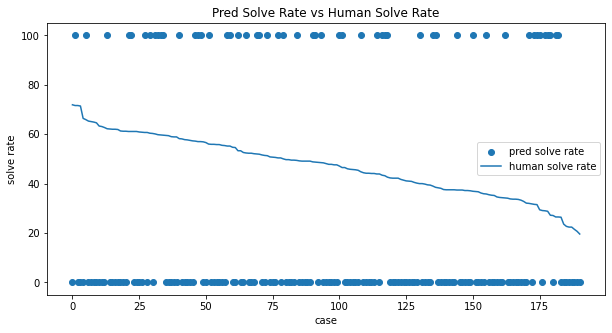

In [79]:
pred_solve_rate_per_case = compute_solve_rate_per_case(df_preds['answer'], df['answer'])
# multiply by 100 to get percentage
pred_solve_rate_per_case = [x * 100 for x in pred_solve_rate_per_case]

# sort pred_solve_rate_per_case in the decreasing order of solve rate
pred_solve_rate_per_case = [x for _,x in sorted(zip(df['solve_rate'], pred_solve_rate_per_case), reverse=True)]

human_solve_rate_per_case = df['solve_rate']
# sort human_solve_rate_per_case in the decreasing order of solve rate
human_solve_rate_per_case = [x for _,x in sorted(zip(df['solve_rate'], human_solve_rate_per_case), reverse=True)]

# plot pred and human solve rate per case
# pred solve rate should be a scatter plot
# human solve rate should be a line plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(range(len(pred_solve_rate_per_case)), pred_solve_rate_per_case, label='pred solve rate')
ax.plot(range(len(human_solve_rate_per_case)), human_solve_rate_per_case, label='human solve rate')
ax.set_xlabel('case')
ax.set_ylabel('solve rate')
ax.set_title('Pred Solve Rate vs Human Solve Rate')
ax.legend()
plt.show()

It seems answers of GPT3 are distributed equally among cases. 

### Chain of thought and vanilla prompting agreement

Here we check if the chain of thought and vanilla prompting agree on the answer.

In [84]:
df_preds_vanilla = pd.read_csv("preds_zeroshot_instruct.csv")
df_preds_stepbystep = pd.read_csv("preds_zeroshot_instruct_stepbystep.csv")

# count how vanilla and step_by_step answers differ
count = 0
for i in range(len(df_preds_vanilla)):
    if same_answers(df_preds_vanilla['answer'][i], df_preds_stepbystep['answer'][i]):
        # print(f"Vanilla answer: " + df_preds_vanilla['answer'][i])
        # print(f"Step by step answer: " + df_preds_stepbystep['answer'][i])
        # print(f"True answer: " + df["answer"][i])
        # print("")
        count += 1

In [85]:
count / len(df_preds_vanilla)

0.8481675392670157

It seems that in most cases CoT prompting indeed helps a bit, but in some cases it hurts. Overall it helps more.

In [91]:
# check how much of these answers that differ are correct for each pred and vanilla
count_vanilla_correct = 0
count_stepbystep_correct = 0
for i in range(len(df_preds_vanilla)):
    if not same_answers(df_preds_vanilla['answer'][i], df_preds_stepbystep['answer'][i]):
        # check if vanilla answer is correct or step by step answer is correct
        if same_answers(df_preds_vanilla['answer'][i], df["answer"][i]):
            count_vanilla_correct += 1
            print(f"Vanilla answer is correct")
        if same_answers(df_preds_stepbystep['answer'][i], df["answer"][i]):
            count_stepbystep_correct += 1
            print(f"Step by step answer is correct")
        print(f"Vanilla answer: " + df_preds_vanilla['answer'][i])
        print(f"Step by step answer: " + df_preds_stepbystep['answer'][i])
        print(f"True answer: " + df["answer"][i])
        print(f"Answer options: ", df["answer_options"][i])
        print("")


Step by step answer is correct
Vanilla answer: (d) Uncle Larry
Step by step answer: (b) Greg
True answer: (b) Greg
Answer options:  (a) Father; (b) Greg; (c) Tina; (d) Uncle Larry

Vanilla answer is correct
Vanilla answer: (d) Smith
Step by step answer: (b) Marie
True answer: (d) Smith
Answer options:  (a) Jean; (b) Marie; (c) Molly; (d) Smith

Vanilla answer is correct
Vanilla answer: (a) Edith
Step by step answer: (b) Joshua Sellers
True answer: (a) Edith
Answer options:  (a) Edith; (b) Joshua Sellers; (c) Muggles; (d) Rick

Vanilla answer: (a) Horace
Step by step answer: (b) Jake
True answer: (d) Lewis
Answer options:  (a) Horace; (b) Jake; (c) John; (d) Lewis

Vanilla answer: (b) Elderly man
Step by step answer: (d) Motorcyclist
True answer: (a) Bug collector
Answer options:  (a) Bug collector; (b) Elderly man; (c) Family man; (d) Motorcyclist

Vanilla answer: (b) Joe Tucker
Step by step answer: (c) Mikey Chanowski
True answer: (d) Shea Callaghan
Answer options:  (a) Hortence Lacom

## Conclusion

GPT3 is not capable of abductive reasoning and common sense to the extent that is needed to sovle these detective puzzles on the human level. 
</br></br>It scores 27% with CoT prompting and 26% with simple prompting while random baseline is 24% and human-level is 47%. 
</br></br>Is it too small for this task? =)